# CT Scan Based COVID Detection & Classification


In [ ]:
"""
!pip install q keras==2.2.2
%tensorflow_version 1.10.0
"""

'\n!pip install q keras==2.2.2\n%tensorflow_version 1.10.0\n'

### Dataset - Kaggle : 
- 1252 CT scans that are positive for SARS-CoV-2 infection (COVID-19) 
- 1230 CT scans for patients non-infected by SARS-CoV-2
- 2482 CT scans in total

https://www.kaggle.com/plameneduardo/sarscov2-ctscan-dataset

In [ ]:
!pip install kaggle


import os
def get_size(path = os.getcwd()):
    print("Calculating Size: ",path)
    total_size = 0
    #if path is directory--
    if os.path.isdir(path):
      print("Path type : Directory/Folder")
      for dirpath, dirnames, filenames in os.walk(path):
          for f in filenames:
              fp = os.path.join(dirpath, f)
              # skip if it is symbolic link
              if not os.path.islink(fp):
                  total_size += os.path.getsize(fp)
    #if path is a file---
    elif os.path.isfile(path):
      print("Path type : File")
      total_size=os.path.getsize(path)
    else:
      print("Path Type : Special File (Socket, FIFO, Device File)" )
      total_size=0
    bytesize=total_size
    print(bytesize, 'bytes')
    print(bytesize/(1024), 'kilobytes')
    print(bytesize/(1024*1024), 'megabytes')
    print(bytesize/(1024*1024*1024), 'gegabytes')
    return total_size


x=get_size("/content/examples")



import os
os.makedirs("/content/.kaggle/")

import json
token = {"username":"farhanhaikhan","key":"f2c0df223af325f0d811a0f18b0c02ca"}
with open('/content/.kaggle/kaggle.json', 'a+') as file:
    json.dump(token, file)

import shutil
os.makedirs("/.kaggle/")
src="/content/.kaggle/kaggle.json"
des="/.kaggle/kaggle.json"
shutil.copy(src,des)


os.makedirs("/root/.kaggle/")
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

!kaggle config set -n path -v /content

#https://towardsdatascience.com/setting-up-kaggle-in-google-colab-ebb281b61463


Calculating Size:  /content/examples
Path Type : Special File (Socket, FIFO, Device File)
0 bytes
0.0 kilobytes
0.0 megabytes
0.0 gegabytes
- path is now set to: /content


In [ ]:
!kaggle datasets download -d plameneduardo/sarscov2-ctscan-dataset

 96% 222M/230M [00:02<00:00, 79.4MB/s]
100% 230M/230M [00:03<00:00, 64.8MB/s]


In [ ]:

src="/content/datasets/plameneduardo/sarscov2-ctscan-dataset/sarscov2-ctscan-dataset.zip"
des="/content/DATA/"
get_ipython().system('unzip -q {} -d {}'.format(src,des))

In [ ]:
DATA_DIR = "/content/DATA"

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import os


import cv2
from tqdm import tqdm
import keras
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
# from tensorflow.keras.models import Model # , Sequential, Input, load_model
from keras.models import  Sequential, Input, load_model, Model # Model,
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [ ]:
cvd = os.path.join(DATA_DIR,"COVID")
ncvd = os.path.join(DATA_DIR,"non-COVID")

In [ ]:
def getExtension(filepath):
  """Returns the extension of the given filepath"""
  complete_filename, file_extension = os.path.splitext(filepath)
  return file_extension

def countExtensions(ListofPaths):
  """Returns a dictionary of element counts present in the directory"""
  files = dict()
  for each in ListofPaths:
    extension = getExtension(each)
    if extension not in files:
      files[extension]=1
    else:
      files[extension]=files[extension]+1
  return files

countExtensions(ListofPaths=os.listdir(cvd))

{'.png': 1252}

In [ ]:

countExtensions(ListofPaths=os.listdir(ncvd))

{'.png': 1229}

In [ ]:
CLASS_LABELS = {0:'non-COVID',1:'COVID'}
CLASS_PATHS = {0:ncvd,1:cvd}
"""
Create a df : 
Format :
Path ClassVal ClassLabel
"""
COLS = ["Path", "ClassVal", "ClassLabel"]
df = pd.DataFrame(columns=COLS)

def merge_list_to_dict(test_keys,test_values):
  """Using dictionary comprehension to merge two lists to dictionary"""
  merged_dict = {test_keys[i]: test_values[i] for i in range(len(test_keys))}
  return merged_dict


for each_class in CLASS_PATHS:
  imgDir = CLASS_PATHS[each_class]
  current_label = CLASS_LABELS[each_class]
  imgList = os.listdir(imgDir)
  for eachImg in imgList:
    imgPath = os.path.join(imgDir,eachImg)
    df = df.append(merge_list_to_dict(COLS,[imgPath, each_class,current_label]),ignore_index=True)
df.head()

,Path,ClassVal,ClassLabel
0,/content/DATA/non-COVID/Non-Covid (120).png,0,non-COVID
1,/content/DATA/non-COVID/Non-Covid (1000).png,0,non-COVID
2,/content/DATA/non-COVID/Non-Covid (594).png,0,non-COVID
3,/content/DATA/non-COVID/Non-Covid (1084).png,0,non-COVID
4,/content/DATA/non-COVID/Non-Covid (10).png,0,non-COVID


In [ ]:
df.tail()

,Path,ClassVal,ClassLabel
2476,/content/DATA/COVID/Covid (387).png,1,COVID
2477,/content/DATA/COVID/Covid (480).png,1,COVID
2478,/content/DATA/COVID/Covid (659).png,1,COVID
2479,/content/DATA/COVID/Covid (1217).png,1,COVID
2480,/content/DATA/COVID/Covid (497).png,1,COVID


In [ ]:
df.shape

(2481, 3)

COVID        1252
non-COVID    1229
Name: ClassLabel, dtype: int64


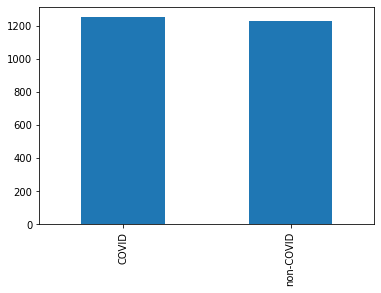

In [ ]:
Class_Counts = df["ClassLabel"].value_counts()
print(Class_Counts)
Class_Counts.plot(kind='bar');

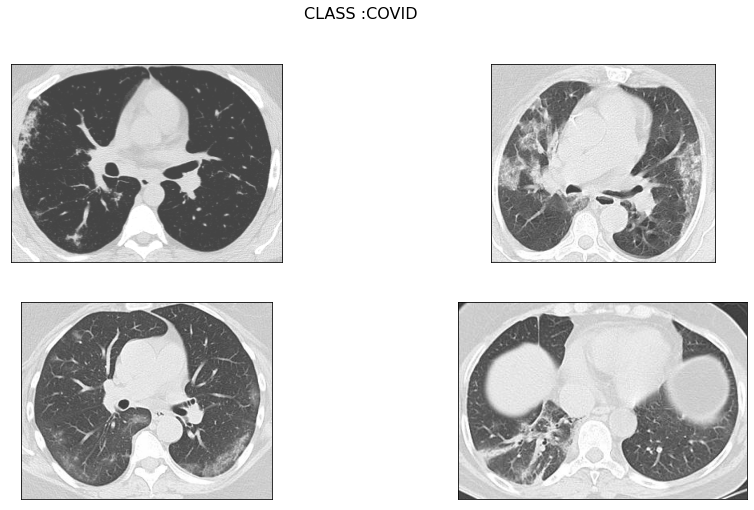

In [ ]:
# Utility Function for Displaying the Images

def displayImages(class_labels, rows, cols):
    fig,ax = plt.subplots(rows,cols, figsize=(15,8))
    fig.suptitle('CLASS :'+class_labels,fontsize = 16)
    selectedImgs  = df['Path'][df['ClassLabel']==class_labels].values 
    count = 0
    for i in range(rows):
        for j in range(cols):
            imgPath = selectedImgs[count]
            img = cv2.imread(imgPath)
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(img)
            count += 1
            
displayImages('COVID',2,2)  

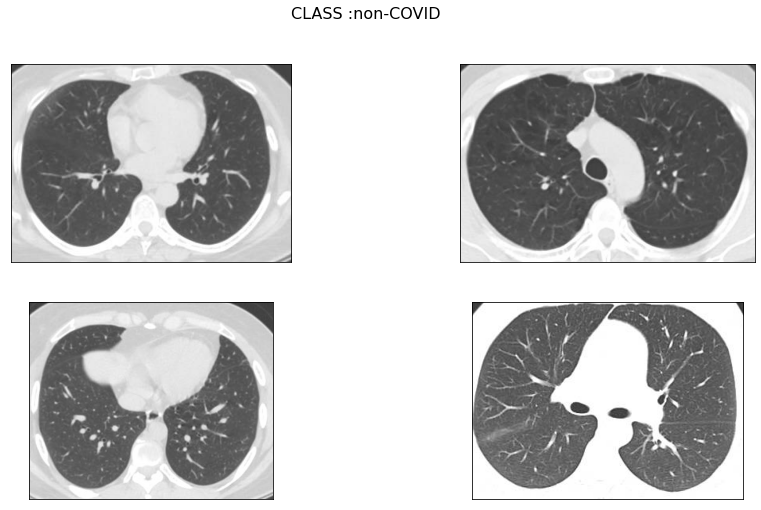

In [ ]:
displayImages('non-COVID',2,2)  

### Train Test Splitting

In [ ]:
from sklearn.model_selection import train_test_split
				
X_train_imgPaths, X_test_imgPaths, y_train_list, y_test_list = train_test_split(df["Path"], df["ClassVal"], test_size=0.25, random_state=42)

### Image Preprocessing

- Image Reading
- Resizing

In [ ]:
def load_data(Paths,Labels,newSize = 64):
    data = np.zeros((len(Paths),newSize,newSize,3 ))
    count = 0
    for eachImg,eachLabel in zip(Paths,Labels):
      img = cv2.imread(eachImg)
      img = cv2.resize(img, (newSize,newSize), interpolation=cv2.INTER_CUBIC)
      data[count] = img
      count+=1
    return data,np.array(Labels)

X_train, y_train = load_data(X_train_imgPaths,y_train_list)
X_test, y_test   = load_data(X_test_imgPaths, y_test_list)

In [ ]:
BATCH_SIZE = 64
EPOCHS = 100
IMG_SIZE=64
N_channels=3



In [ ]:
len(CLASS_LABELS)

2

## Applying Keras Resnet

In [ ]:
"""
from keras.applications import ResNet101

# from keras.applications.resnet50 import ResNet50

BaseModel = ResNet101(weights='imagenet',input_shape=(IMG_SIZE,IMG_SIZE,3),include_top = False) # len(CLASS_LABELS) # ,classes=1
"""

"\nfrom keras.applications import ResNet101\n\n# from keras.applications.resnet50 import ResNet50\n\nBaseModel = ResNet101(weights='imagenet',input_shape=(IMG_SIZE,IMG_SIZE,3),include_top = False) # len(CLASS_LABELS) # ,classes=1\n"

In [ ]:
"""
def build_model(BaseModel):
  
    # BaseModel = ResNet50(weights='imagenet',input_shape=(IMG_SIZE,IMG_SIZE,3),classes=1,include_top = False)
    input = Input(shape=(IMG_SIZE, IMG_SIZE,N_channels))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = BaseModel(x)

    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    # multi output
    output = Dense(1,activation = 'softmax', name='root')(x) # len(CLASS_LABELS)
 

    # model
    model = Model(input,output)
    return model

# Model = build_model(BaseModel)
# Model = ResNet101(weights='imagenet',input_shape=(IMG_SIZE,IMG_SIZE,3),classes=1,include_top = False) # len(CLASS_LABELS) # ,classes=1
"""
BaseModel = DenseNet121(weights='imagenet', include_top=False)
BaseModel.summary()


29089792/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
_______________________

In [ ]:
def build_densenet():

    input = Input(shape=(IMG_SIZE, IMG_SIZE,N_channels))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = BaseModel(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    return model


In [ ]:
Model = build_densenet()
optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
# Model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
Model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
Model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400

### Model HyperParameters
Initialize Checkpoints and Reduce Learning Rate at Stagnation.

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('CTScan_Model.h5', verbose=1, save_best_only=True)

### Data Augmentation

In [ ]:
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=90, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)

In [ ]:
X_train.shape

(1860, 64, 64, 3)

In [ ]:
X_test.shape

(621, 64, 64, 3)

In [ ]:
y_train.shape

(1860,)

In [ ]:
y_test.shape

(621,)

In [ ]:

X_train = np.asarray(X_train).astype('float32')
X_test= np.asarray(X_test).astype('float32')
# y_train= np.asarray(y_train).astype('float32').reshape((-1,1))
# y_test= np.asarray(y_test).astype('float32').reshape((-1,1))
y_train = to_categorical(np.asarray(y_train).astype('float32'))
y_test = to_categorical(np.asarray(y_test).astype('float32'))

In [ ]:
one_hot_encode = to_categorical(y_test)
one_hot_encode

array([[[0., 1.],
        [1., 0.]],

       [[0., 1.],
        [1., 0.]],

       [[1., 0.],
        [0., 1.]],

       ...,

       [[0., 1.],
        [1., 0.]],

       [[0., 1.],
        [1., 0.]],

       [[0., 1.],
        [1., 0.]]], dtype=float32)

In [ ]:
"""
import tensorflow as tf

X_train = tf.convert_to_tensor(X_train)
X_test= tf.convert_to_tensor(X_test)
y_train=tf.convert_to_tensor(y_train)
y_test= tf.convert_to_tensor(y_test)
"""

'\nimport tensorflow as tf\n\nX_train = tf.convert_to_tensor(X_train)\nX_test= tf.convert_to_tensor(X_test)\ny_train=tf.convert_to_tensor(y_train)\ny_test= tf.convert_to_tensor(y_test)\n'

### Training

In [ ]:
# Fits the model on batches with real-time data augmentation
hist = Model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_test, y_test))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/100
29/29 - 43s - loss: 1.2240 - accuracy: 0.5217 - val_loss: 1.6528 - val_accuracy: 0.4396

Epoch 00001: val_loss improved from inf to 1.65275, saving model to CTScan_Model.h5
Epoch 2/100
29/29 - 12s - loss: 1.0263 - accuracy: 0.5757 - val_loss: 0.9580 - val_accuracy: 0.5346

Epoch 00002: val_loss improved from 1.65275 to 0.95796, saving model to CTScan_Model.h5
Epoch 3/100
29/29 - 13s - loss: 0.9442 - accuracy: 0.6136 - val_loss: 1.3295 - val_accuracy: 0.5636

Epoch 00003: val_loss did not improve from 0.95796
Epoch 4/100
29/29 - 12s - loss: 0.8800 - accuracy: 0.6353 - val_loss: 1.0976 - val_accuracy: 0.5781

Epoch 00004: val_loss did not improve from 0.95796
Epoch 5/100
29/29 - 13s - loss: 0.7515 - accuracy: 0.6600 - val_loss: 0.5912 - val_accuracy: 0.7085

Epoch 00005: val_loss improved from 0.95796 to 0.59118, saving model to CTScan_Model.h5
Epoch 6/100
29/29 - 13s - loss: 0.7452 - accuracy: 0.6988 - val_loss: 0.9381 - val_accuracy: 0.6039

Epoch 00006: val_loss did not im

### Trying Different Models

In [ ]:
"""
ResNetModel = ResNet101(weights='imagenet',input_shape=(IMG_SIZE,IMG_SIZE,3),classes=1,include_top = False) # len(CLASS_LABELS) # ,classes=1
optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
ResNetModel.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
ResNetModel.summary()

annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('CTScan_ResNetModel.h5', verbose=1, save_best_only=True)

# Fits the model on batches with real-time data augmentation
hist = ResNetModel.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=50,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_test, y_test))
"""

"\nResNetModel = ResNet101(weights='imagenet',input_shape=(IMG_SIZE,IMG_SIZE,3),classes=1,include_top = False) # len(CLASS_LABELS) # ,classes=1\noptimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)\nResNetModel.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])\nResNetModel.summary()\n\nannealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-4)\ncheckpoint = ModelCheckpoint('CTScan_ResNetModel.h5', verbose=1, save_best_only=True)\n\n# Fits the model on batches with real-time data augmentation\nhist = ResNetModel.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),\n               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,\n               epochs=50,\n               verbose=2,\n               callbacks=[annealer, checkpoint],\n               validation_data=(X_test, y_test))\n"

In [ ]:
"""
from keras.applications import EfficientNetB0
EfficientNetModel = EfficientNetB0(weights='imagenet',input_shape=(IMG_SIZE,IMG_SIZE,3),classes=1,include_top = False) # len(CLASS_LABELS) # ,classes=1
optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
EfficientNetModel.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
EfficientNetModel.summary()

annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('CTScan_ResNetModel.h5', verbose=1, save_best_only=True)

# Fits the model on batches with real-time data augmentation
hist = EfficientNetModel.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=50,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_test, y_test))
"""

"\nfrom keras.applications import EfficientNetB0\nEfficientNetModel = EfficientNetB0(weights='imagenet',input_shape=(IMG_SIZE,IMG_SIZE,3),classes=1,include_top = False) # len(CLASS_LABELS) # ,classes=1\noptimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)\nEfficientNetModel.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])\nEfficientNetModel.summary()\n\nannealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-4)\ncheckpoint = ModelCheckpoint('CTScan_ResNetModel.h5', verbose=1, save_best_only=True)\n\n# Fits the model on batches with real-time data augmentation\nhist = EfficientNetModel.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),\n               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,\n               epochs=50,\n               verbose=2,\n               callbacks=[annealer, checkpoint],\n               validation_data=(X_test, y_test))\n"

# Results

### Confusion Matrix

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


[[281  21]
 [ 49 270]]


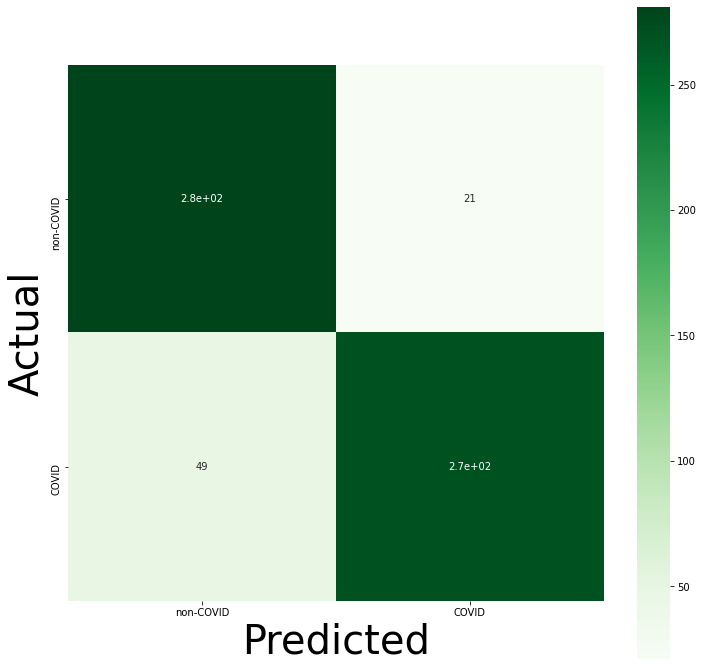

In [ ]:
y_pred = Model.predict(X_test)
y_predict = np.argmax(y_pred, axis= 1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_predict)
plt.figure(figsize=(12,12))
ax= sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=CLASS_LABELS.values(),yticklabels=CLASS_LABELS.values())
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
print(cm)

### Accuracy and Loss Curve

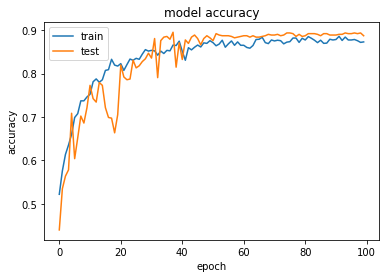

In [ ]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

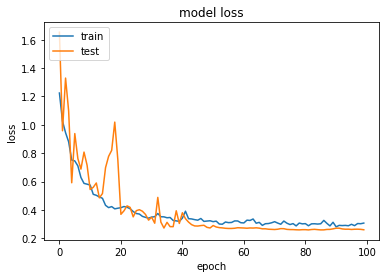

In [ ]:
# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Running Inferences

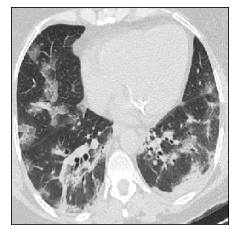

Class Probabilities : [0.08268705 0.917313  ]
Prediction: COVID


In [ ]:
import warnings
warnings.filterwarnings("ignore")
from skimage import io
from keras.preprocessing import image

def preprocessImg(img):
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)
  x /= 255
  return x

def RunInferences(imgPath,display=True):
  img = image.load_img(imgPath, grayscale=False, target_size=(64, 64))

  

  x = preprocessImg(img)

  custom = Model.predict(x)

  if display:
    displayImg= image.load_img(imgPath, grayscale=False, target_size=(256, 256))
    plt.imshow(displayImg)
    plt.xticks([])
    plt.yticks([])
    plt.show()

  a=custom[0]
  ind=np.argmax(a)
  print("Class Probabilities :",a)
  print('Prediction:',CLASS_LABELS[ind])
  return ind
imgPath = '/content/DATA/COVID/Covid (10).png'
RunInferences(imgPath,display=True);

In [ ]:
Model.save('/content/Best_Model88')

INFO:tensorflow:Assets written to: /content/Best_Model88/assets


In [ ]:
get_size('/content/Best_Model88')

Calculating Size:  /content/Best_Model88
Path type : Directory/Folder
99258750 bytes
96932.373046875 kilobytes
94.66052055358887 megabytes
0.09244191460311413 gegabytes


99258750

In [ ]:


get_size('/content/CTScan_Model.h5')

Calculating Size:  /content/CTScan_Model.h5
Path type : File
88596104 bytes
86519.6328125 kilobytes
84.49182891845703 megabytes
0.0825115516781807 gegabytes


88596104

In [ ]:
import os
import zipfile


def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))


def zipper(dir_path, zip_path):
    zipf = zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED)
    zipdir(dir_path, zipf)
    zipf.close()

zipper('/content/Best_Model88', "/content/Best_Model88.zip")

In [ ]:


get_size('/content/Best_Model88.zip')

Calculating Size:  /content/Best_Model88.zip
Path type : File
78754479 bytes
76908.6708984375 kilobytes
75.10612392425537 megabytes
0.07334582414478064 gegabytes


78754479

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil

shutil.copy('/content/CTScan_Model.h5', "/content/drive/MyDrive/CTScan/CTScan_Model.h5")
shutil.copytree('/content/Best_Model88',"/content/drive/MyDrive/CTScan/Best_Model88")

'/content/drive/MyDrive/CTScan/Best_Model88'

In [ ]:
shutil.copy('/content/Best_Model88.zip', "/content/drive/MyDrive/CTScan/Best_Model88.zip")

'/content/drive/MyDrive/CTScan/Best_Model88.zip'

In [ ]:
"""
import shutil

shutil.copytree("/content/drive/MyDrive/CTScan/Best_Model88",'/content/Best_Model88')
"""

'/content/Best_Model88'

In [ ]:
#https://drive.google.com/file/d/1ctYN3KVdutNcfONaJH3hHSUsq1U7BqB8/view?usp=sharing

In [ ]:
!gdown --id 1ctYN3KVdutNcfONaJH3hHSUsq1U7BqB8

Downloading...
From: https://drive.google.com/uc?id=1ctYN3KVdutNcfONaJH3hHSUsq1U7BqB8
To: /content/Best_Model88.zip
78.8MB [00:01, 55.6MB/s]


In [ ]:
get_ipython().system('unzip -q {} -d {}'.format("/content/Best_Model88.zip","/content/Best_Model88"))

In [ ]:
from tensorflow import keras
Model = keras.models.load_model('/content/Best_Model88/content/Best_Model88')

import warnings
warnings.filterwarnings("ignore")
from skimage import io
from keras.preprocessing import image
import numpy as np

def preprocessImg(img):
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)
  x /= 255
  return x


def RunInferences(imgPath,display=True):
  img = image.load_img(imgPath, grayscale=False, target_size=(64, 64))
  x = preprocessImg(img)
  custom = Model.predict(x)
  if display:
    displayImg= image.load_img(imgPath, grayscale=False, target_size=(256, 256))
    plt.imshow(displayImg)
    plt.xticks([])
    plt.yticks([])
    plt.show()

  a=custom[0]
  ind=np.argmax(a)
  print("Class Probabilities :",a)
  print('Prediction:',CLASS_LABELS[ind])
  return ind


In [ ]:
!wget https://www.itnonline.com/sites/default/files/styles/content_large/public/download.png

--2021-04-18 15:40:13--  https://www.itnonline.com/sites/default/files/styles/content_large/public/download.png
Resolving www.itnonline.com (www.itnonline.com)... 104.18.12.65, 104.18.13.65, 2606:4700::6812:c41, ...
Connecting to www.itnonline.com (www.itnonline.com)|104.18.12.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 286033 (279K) [image/png]
Saving to: ‘download.png’

download.png        100%[===================>] 279.33K  --.-KB/s    in 0.02s   

2021-04-18 15:40:13 (12.9 MB/s) - ‘download.png’ saved [286033/286033]



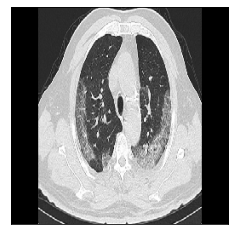

Class Probabilities : [0.08462637 0.91537356]
Prediction: COVID


In [ ]:
import matplotlib.pyplot as plt

CLASS_LABELS = {0:'non-COVID',1:'COVID'}
imgPath = 'download.png'
RunInferences(imgPath,display=True);